In [1]:
import functools
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

import sys
sys.path.append('../../pyutils')
import metrics
import utils

# One-Dimensional Kernel Smothers

## K neirest neighbours:

$$\hat{f}(x) = \frac{1}{K} \sum_{x_i \in N_K(x)} y_i$$

with $N_K(x)$ the $K$ closest points of $x$.

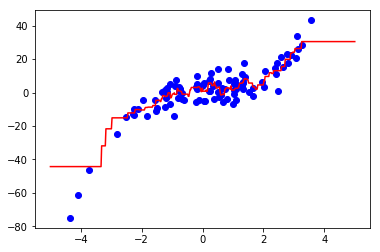

In [2]:
class MyKNN:
    
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
    def get_k_closest(self, x):
        
        dists = np.empty(len(self.X))
        for i in range(len(self.X)):
            dists[i] = (self.X[i] - x) @ (self.X[i] - x)
        
        p = dists.argsort()
        yp = self.y[p]
        return yp[:self.k]
        
        
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):    
            clos = self.get_k_closest(X[i])
            #print(clos.shape)
            y[i] = np.mean(clos)
        return y
            
X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))


clf = MyKNN(k=5)
clf.fit(X,y)
preds = clf.predict(X)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

## Nadaraya-Watso kernel-weigthed average

$$\hat{f}(x_0) = \frac{\sum_{i=1}^N K(x_0, x_i)y_i}{\sum_{i=1}^N K(x_0, x_i)}$$


## Epanechnikov quadratic kernel

$$K_\lambda(x_0,x) = D(\frac{|x-x_0|}{\lambda})$$

with

$$D(t) = 
\begin{cases}
    \frac{3}{4}(1-t^2) & \text{if } |t| \leq 1\\
    0 & \text{otherwise}
\end{cases}
$$

$\lambda$ represent the with of the neighbourhood, it is constant.  
It can be made variables:

$$K_\lambda(x_0,x) = D(\frac{|x-x_0|}{h_\lambda(x_0)})$$

Large $\lambda$ implies lower variance but higher bias.

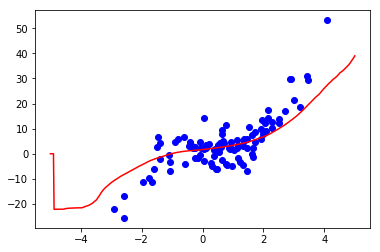

In [3]:


class NadarayaWatson:
    
    def __init__(self, kernel):
        self.kernel = kernel
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        
        
    def get_pred(self, x):
        num = 0
        den = 0
        for i in range(len(self.X)):
            d = self.kernel(x, self.X[i])
            num += d * self.y[i]
            den += d
        
        return 0 if den == 0 else num / den    
        
    def predict(self, X):
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
    
def epanechnikov(lbda, x0, x):
    t = np.linalg.norm(x - x0) / lbda
    if t <= 1:
        return 3/4 * (1-t**2)
    else:
        return 0
    

X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))

kernel = functools.partial(epanechnikov, 2)
clf = NadarayaWatson(kernel)
clf.fit(X,y)
preds = clf.predict(X)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

# Local Linear Regression

Locally weighted regression solves a different weighted least squares problem at each target point $x_0$:

$$\min_{\alpha(x_0), \beta(x_0)} \sum_{i=1}^N K(x_0, x_i) [y_i - \alpha(x_0) - \beta(x_0)x_i]^2$$

The estimate is $\hat{f}(x_0) = \hat{\alpha}(x_0) + \hat{\beta}(x_0)x_0$

The estimate can be found by solving a weighted least square at the target point:

$$\hat{f}(x_0) = b(x_0)^T(B^TW(x_0)B)^{-1}B^TW(x_0)y$$

with:
- $b(x) \in \mathbb{R}^{p+1}$ the vector $x$ with an extra column $1$ at the beginning
- $B \in \mathbb{R}^{N*(p+1)}$ matrix where the i-th row is $b(x_i)$
- $W(x_0) \in \mathbb{R}^{N*N}$ diagonal matrix where $w_{ii} = K(x_0,x_i)$

The estimate is linear in $y_i$:
$$\hat{f}(x_0) = \sum_{i=1}^N l_i(x_0)y_i$$

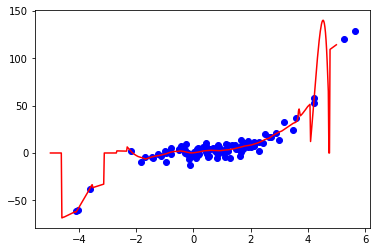

In [4]:
class LocallyWeightedRegression:
    
    def __init__(self, kernel):
        self.kernel = kernel
        
    def fit(self, X, y):
        self.X = X
        self.B = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        self.y = y
        
        
    def get_pred(self, x):
        b = np.ones(len(x) + 1)
        b[1:] = x
        
        
        W = np.zeros((len(self.X), len(self.X)))
        for i in range(len(self.X)):
            W[i,i] = self.kernel(x, self.X[i])
            
        BWB = self.B.T @ W @ self.B + 1e-6 * np.eye(len(b))
        beta = np.linalg.inv(BWB) @ self.B.T @ W @ y
        return b @ beta

        
    def predict(self, X):
        
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
    
    
X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))

kernel = functools.partial(epanechnikov, 0.5)
clf = LocallyWeightedRegression(kernel)
clf.fit(X,y)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500).reshape(-1, 1)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

## Local Polynomial Regression

We can fit local polynomials of any degree $d$:

$$\min_{\alpha(x_0), \beta_j(x_0), j=1,\text{...},d} \sum_{i=1}^N K(x_0, x_i) [y_i - \alpha(x_0) - \sum_{j=1}^d \beta_j(x_0)x_i^j]^2$$

It tend to recude bias of local regression, but also increase variance

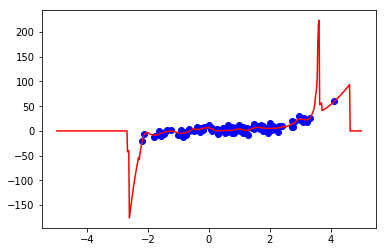

In [5]:
class LocallyPolynomialRegression:
    
    def __init__(self, kernel, degree):
        self.kernel = kernel
        self.d = degree
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.B = self.extend_x(self.X)
    
    def extend_x(self, X):
        n = X.shape[0]
        p = X.shape[1]
        B = np.empty((n, 1 + self.d*p))
        B[:, 0] = np.ones(n)
        
        for d in range(self.d):
            B[:, 1+p*d:1+p*d+p] = X**(d+1)
        return B
        
    
        
    def get_pred(self, x):
        b = self.extend_x(x.reshape(1, -1))[0]
        
        W = np.zeros((len(self.X), len(self.X)))
        for i in range(len(self.X)):
            W[i,i] = self.kernel(x, self.X[i])
            
        BWB = self.B.T @ W @ self.B + 1e-6 * np.eye(len(b))
        beta = np.linalg.inv(BWB) @ self.B.T @ W @ y
        return b @ beta

        
    def predict(self, X):
        
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
    
    
X = 0.2*np.random.randn(100,1)**2 + 1.5*np.random.randn(100,1) + 0.3
y = 0.8*X[:,0] - 0.3*X[:,0]**2 + 0.8*X[:,0]**3 + 1.3 + 5*np.random.randn(len(X))

kernel = functools.partial(epanechnikov, 0.5)
clf = LocallyPolynomialRegression(kernel, degree=4)
clf.fit(X,y)

plt.scatter(X, y, c='b')

xx = np.linspace(-5, 5, 500).reshape(-1, 1)
plt.plot(xx, clf.predict(xx), c='r')
plt.show()

# Selecting the width of the kernel

$\lambda$ control the kernel width, might be different among kernels:
- Epanechnikov: $\lambda$ is the radius of the support region
- Gaussian: $\lambda$ is the standard deviation
- KNN: expressed as $k/n$, number of neighbors

With a small $\lambda$, the number of $y_i$ and smaller, which increase the variance,  and closer to $x_0$, which reduce the bias.  
With a high $\lambda$, there will be lots of $y_i$, and averaging reduces the variance, but the observations are farther from $x_i$, that increase the bias.

# Local Regression in $\mathbb{R}^p$

The same kernel techniques (KNN, local linear/polynomial regression) can be applied as $p$ increases.  
But one effect of the curse of dimensionality is that the fraction of points close to boundaries increase as the dimension grows, the kernel function should me modified to accomodate that.  

What's more, as $p$ increases, in order to both maintaint the localness (low bias) and a good number of neighbors (variance), the number of obervations must increase exponentially.

# Structured Local Regression in $\mathbb{R}^p$

## Structured Kernels

The default spheral kernel gives equal weight to each feature, a strategy could be to standardize the data. Another approch is to use a weight matrix to give different importance for the features:
$$K_{\lambda,A} = D( \frac{(x-x_0)^T A (x - x_0)}{\lambda})$$

with $A \in \mathbb{R}^{p*p}$ a positive semi-definite matrix of weights.  

If $A$ is diagonal, it's possible to control the influence of each feauture individually.  
Models can try to learn $A$, like the project-pursuit regression model.  
In general, models with $A$ are cumbersone, and they are better structurel models.

## Varying coefficient models

We divide $X$ into a set $(X_1, \text{...}, X_q)$ with $q < p$, and the reminding features are in $Z$.  

We define the linear model:
$$f(X) = \alpha(Z) + \sum_{i=1}^q \beta_i(Z)X_i$$

We can fit the model with locally weighted regression:

$$\min_{\alpha(z_0), \beta_j(z_0), j=1,\text{...},q} \sum_{i=1}^N K(z_0, z_i) [y_i - \alpha(z_0) - \sum_{j=1}^q x_{ij} \beta_j(z_0)]^2$$

# Local Likelihood and Other Models

We can extend log-likehilood by adding observations weights, computed locally with kernels:

$$l(\beta(x_0)) \sum_{i=1}^N K(x_0, x_i) l(y_i, x_i^T \beta(x_0))$$

We can extend the logistig regression model:

$$P(G=g|X=x) = \frac{\exp(\beta_g^Tx)}{1 + \sum_{k=1}^K \exp(\beta_k^Tx)}$$

The local likelihood can be written as:

$$\sum_{i=1}^N K(x_o,x_i) [\beta_g(x_0)^T(x_i - x_0) - \log (1 + \sum_{k=1}^K \exp(\beta_k(x_0)^T(x_i - x_0))  ]$$

The estimated probability is:

$$\hat{p} = P(G=g|X=x_0) = \frac{\exp(\hat{\beta}_j(x_0))}{1 + \sum_{k=1}^K \exp(\beta_k(x_0))}$$

# Kernel Density Estimation and Classification

## Kernel density estimation

Let $x_1, \text{...},x_N$ a sample drawn from $f_X(x)$, we wish to estimate $f_X$ at $x_0$.  
We can use the smooth Parzen estimate:

$$\hat{f}_X(x_0) = \frac{1}{N\lambda} \sum_{i=1}^N K_\lambda(x_0,x_i)$$

One commonon estimate is the Gausian Kernel:

$$K_\lambda(x_0, x) = \frac{1}{\lambda \sqrt{2\pi}} \exp(-\frac{(x_0 - x)^2}{2\lambda^2})$$

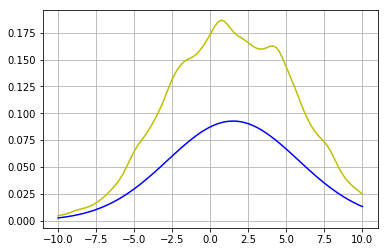

In [6]:
class ParzenEstimate:
    
    def __init__(self, kernel, lbda):
        self.kernel = kernel
        self.lbda = lbda
        
    def fit(self, X):
        self.X = X
        
    def get_dens(self, x):
        d = 0
        for xi in self.X:
            d += self.kernel(x, xi)
        d /= (len(self.X) * self.lbda)
        return d
        
    def predict(self, X):
        return np.array([self.get_dens(x) for x in X])
    
def gauss_kernel(lbda, x0, x):
    den = lbda * math.sqrt(2 * math.pi)
    num = np.exp(-(x0 - x)**2 / (2*lbda**2))
    return num / den

LBDA = 0.5
X = np.random.randn(5000) * 4.3 + 1.5
clf = ParzenEstimate(functools.partial(gauss_kernel, LBDA), LBDA)
clf.fit(X)

xx = np.linspace(-10, 10, 100)
d = np.array([gauss_kernel(4.3, x, 1.5) for x in xx])
preds = clf.predict(xx)



plt.plot(xx, d, c='b')
plt.plot(xx, preds, c='y')
plt.grid()
plt.show()

## Kernel density classification

We can use the density estimate to solve the classification problem, using Bayes theorem.

$$P(G = k | X = x_0) = \frac{\hat{f}_k(x_0) \hat{\pi}_k}{\sum_{l=1}^K \hat{f}_l(x_0) \hat{\pi}_l}$$

Let $\pi_k$ the prior probability of class $k$:
$$P(G = k) = \pi_k$$

Let $f_k(x)$ the class conditional density of $X$ in class $G = k$:
$$P(X \in T | G = k) = \int_T f_k(x)dx$$

We can find an estimate of the propability:

$$P(G = k | X = x_0) = \frac{\hat{f}_k(x_0) \hat{\pi}_k}{\sum_{l=1}^K \hat{f}_l(x_0) \hat{\pi}_l}$$

When classification is the goal, learning class densities in unnecessary and might be misleading. We only need un estimate of the posterior near the decision boundary

In [7]:
X = np.random.randn(1000) * 4.3 + 1.5
y = (X > 1.5).astype(np.int)

X0 = X[y == 0]
X1 = X[y == 1]

LBDA = 0.5
kernel = functools.partial(gauss_kernel, LBDA)
clf0 = ParzenEstimate(kernel, LBDA)
clf0.fit(X0)
clf1 = ParzenEstimate(kernel, LBDA)
clf1.fit(X1)

pi1 = np.mean(y)
pi0 = 1 - pi1

def make_pred(x):
    d0 = clf0.predict([x])
    d1 = clf1.predict([x])
    
    num = pi1 * d1
    den = (pi0*d0 + pi1*d1)
    p = num/den
    return 1 if p > 0.5 else 0

preds = np.array([make_pred(x) for x in X])
print('accuracy:', np.mean(y==preds))

accuracy: 0.99


### Naive Bayes Classifier

We have $K$ classes, and the observations have each $p$ features, that are independant:

$$P(x|G_k) = \prod_{j=1}^p P(x_j|G_k)$$

$$P(G_k|x_1, \text{...},x_p) \propto P(G_k,x_1,\text{...},x_p)$$
$$P(G_k,x_1,\text{...},x_p) = P(G_k) \prod_{j=1}^p P(x_j|G_k)$$

We can make new predictions:

$$\hat{g} = \arg \max_{k} P(G_k) \prod_{j=1}^p P(x_j|G_k)$$

Let's define $\pi_k = P(G=k)$, and $f_{kj}(x)$ the class conditional density of feature $x_j$ for class $k$.

$$\hat{g} = \arg \max_{k} \pi_k \prod_{j=1}^p f_{kj}(x_j)$$

### Gaussian naive Bayes

We can use a Gaussian distribution to estimate the class conditional desnity of each feature.  
For each class and feature, we compute the mean $\mu_{kj}$ and the variance $\sigma^2_{kj}$ of the observations.  

Then we can compute the density:

$$f_{kj}(x_j) = \frac{1}{ \sqrt{2\pi\sigma^2_{kj}}} \exp(-\frac{(x_j - \mu_{kj})^2}{2\sigma^2_{kj}})$$

In [8]:
def gen_toy_class(N, noise=0.001):
    X = 2.8 * np.random.randn(N, 4)**1 + 4.67
    v1 = 1.5*X[:, 0] + 2.3*X[:, 1] - 0.3*X[:, 2] + 4.5 + noise*np.random.randn(len(X)) 
    v2 = 1.7*X[:, 0] + 0.4*X[:, 1] + 2.3*X[:, 2] - 3.7 + noise*np.random.randn(len(X))
    v3 = -0.6*X[:, 0] + 5.8*X[:, 1] - 1.3*X[:, 2] + 0.1 + noise*np.random.randn(len(X))
    V = np.vstack((v1, v2, v3)).T
    g = np.argmax(V, axis=1)
    return X, g

class GaussianNaiveBayes:
    
    def __init__(self):
        pass
    
    
    def fit_priors(self):
        #compute prior class probabilities
        self.priors = np.empty(self.K)
        for k in range(self.K):
            self.priors[k] = len(self.y[self.y == k]) / len(self.y)
            
    def fit_densities(self):
        #compute class conditional density for each feature
        p = self.X.shape[1]
        self.dens_mu = np.empty((self.K, p))
        self.dens_std = np.empty((self.K, p))
        
        for k in range(self.K):
            Xk = self.X[self.y == k]
            for j in range(p):
                self.dens_mu[k,j] = np.mean(Xk[:,j])
                self.dens_std[k,j] = np.std(Xk[:,j])
        
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.K = np.max(self.y) + 1
        self.fit_priors()
        self.fit_densities()
        
    def get_class_cond_density(self, x, k, j):
        mu = self.dens_mu[k,j]
        std = self.dens_std[k,j]
        den = 1 / math.sqrt(2*math.pi*std**2)
        num = math.exp(-((x[j] - mu)**2)/(2*std**2))
        return num / den
        
    def get_pred(self, x):
        vals = np.empty(self.K)
        
        for k in range(self.K):
            v = self.priors[k]
            for j in range(len(x)):
                v *= self.get_class_cond_density(x, k, j)
            vals[k] = v
        
        return np.argmax(vals)
        
        
    def predict(self, X):
        
        y = np.empty(len(X))
        for i in range(len(X)):    
            y[i] = self.get_pred(X[i])
        return y
        
        
        
        
X, y = gen_toy_class(5000, noise=1e-3)

clf = GaussianNaiveBayes()
clf.fit(X, y)
preds = clf.predict(X)

print('accuracy:', np.mean(y==preds))

accuracy: 0.8638


We can derive the log-odds probability of naive bayes:
    
$$\log \frac{P(G_k|x}{P(G_K|X} = \log \frac{\pi_k f_k(x)}{\pi_K f_K(x)}$$

$$\log \frac{P(G_k|x}{P(G_K|X} = \log \frac{\pi_k}{\pi_K} + \sum_{j=1}^p \log \frac{f_{kj}(x)}{f_{Kj}(x)}$$

# Radial Basis Functions and Kernels

A RBF model combine both the smoothing kernel functions and the basis expansions function.  
The model is of the form: 
$$f(x) = \sum_{j=1}^M \phi_{\lambda j} (||x - \zeta_j||) \beta_j$$

Each basis element has a location or protopype parameter $\zeta_j \in \mathbb{R}^p$, a scale parameter $\lambda_j \in \mathbb{R}$, and each basis has it's coefficient $\beta_j$.  
$\phi_\lambda$ is the the RBF function, a common one is the Gaussian RBF:

$$\phi_\lambda(r) = \exp (-\frac{r^2}{\lambda^2})$$

Which leads to the following model:

$$f(x) = \sum_{j=1}^M \exp(-\frac{(x - \zeta_j)^T(x - \zeta_j)}{\lambda_j^2}) \beta_j$$

## Gaussian RBF derivatives

$$\frac{\partial \phi_\lambda(x, \zeta)}{\partial x} = \frac{2}{\lambda^2} * \phi_\lambda(x,\zeta) * (\zeta - x)$$
$$\frac{\partial \phi_\lambda(x, \zeta)}{\partial \zeta} = \frac{2}{\lambda^2} * \phi_\lambda(x,\zeta) * (x - \zeta)$$
$$\frac{\partial \phi_\lambda(x, \zeta)}{\partial \lambda} = \frac{2}{\lambda^3} * \phi_\lambda(x,\zeta) * (x - \zeta)^T (x - \zeta)$$

In [9]:
x = 0.1 * np.random.randn(5).astype(np.float32)
c = 0.1 * np.random.randn(5).astype(np.float32)
lbda = 0.9

out = np.exp(-((x - c) @ (x - c))/lbda**2)
dx = 2/lbda**2 * out * (c-x)
dc = 2/lbda**2 * out * (x-c)
dlbda = 2/lbda**3 * out * (x - c) @ (x - c)

tx = torch.tensor(x, requires_grad=True)
tc = torch.tensor(c, requires_grad=True)
tlbda = torch.tensor(lbda, requires_grad=True)
tout = torch.exp(-((tx - tc) @ (tx - tc))/tlbda**2)
tout.backward()

print(out)
print(tout.data.numpy())
print(metrics.tdist(out, tout.data.numpy()))

print(dx)
print(tx.grad.data.numpy())
print(metrics.tdist(dx, tx.grad.data.numpy()))

print(dc)
print(tc.grad.data.numpy())
print(metrics.tdist(dc, tc.grad.data.numpy()))


print(dlbda)
print(tlbda.grad.data.numpy())
print(metrics.tdist(dlbda, tlbda.grad.data.numpy()))

0.9025619015138693
0.9025619
1.4860086494650204e-09
[-0.11106457  0.0888723   0.49425295 -0.01354531  0.38432643]
[-0.11106458  0.08887231  0.494253   -0.01354531  0.3843265 ]
8.592934e-08
[ 0.11106457 -0.0888723  -0.49425295  0.01354531 -0.38432643]
[ 0.11106458 -0.08887231 -0.494253    0.01354531 -0.3843265 ]
8.592934e-08
0.20561965
0.20561966
1.4901161e-08


## RBF Network

Let $X \in \mathbb{R}^{N*p}$ the matrix of observations.  
Let $C \in \mathbb{R}^{M*p}$ the matrix of RBF mean parameters.  
Let $\lambda \in \mathbb{R}^{M}$ the vector of RBF std parameters.  
Let $\beta \in \mathbb{R}^M$ the vector of coefficients for the model.  
Let $y \in \mathbb{R}^N$ the vector of observations labels.

The model is: 

$$\hat{y} = f(x) = \sum_{j=1}^M \phi_{\lambda j} (||x - C_j||) \beta_j$$

We can use the MSE to define the error function of the model:

$$J(C,\beta,\lambda) = \sum_{i=1}^N (y_i - f(X_i))^2$$

The different parameters $(C, \beta, \lambda)$ can be learned using a gradient algorithm


$$\frac{\partial J}{\partial X_{ik}} = d\hat{y}_i \sum_{j=1}^M \beta_j d\phi_k$$
with $d\hat{y} = \frac{\partial J}{\partial \hat{y}}$ and $d\phi = \frac{\partial \phi_\lambda (X_i, C_j)}{\partial X_i}$

$$\frac{\partial J}{\partial C_{kj}} = \sum_{i=1}^N d\hat{y}_i \beta_k d\phi_j$$
with $d\hat{y} = \frac{\partial J}{\partial \hat{y}}$ and $d\phi = \frac{\partial \phi_\lambda (X_i, C_k)}{\partial C_k}$

$$\frac{\partial J}{\partial \lambda_{j}} = \sum_{i=1}^N d\hat{y}_i \beta_k d\phi$$
with $d\hat{y} = \frac{\partial J}{\partial \hat{y}}$ and $d\phi = \frac{\partial \phi_\lambda (X_i, C_j)}{\partial \lambda}$

$$\frac{\partial J}{\partial \beta_{j}} = \sum_{i=1}^N d\hat{y}_i \phi_\lambda(X_i,C_j)$$
with $d\hat{y} = \frac{\partial J}{\partial \hat{y}}$

In [10]:
N = 50
M = 7
p = 5
X = 0.1 * np.random.randn(N,p).astype(np.float32)
C = 0.1 * np.random.randn(M,p).astype(np.float32)
beta = np.random.randn(M).astype(np.float32)
lbda = np.random.randn(M).astype(np.float32)
y = np.random.randn(N).astype(np.float32)


#matrix formula
#Xe[i,j,k] = X[j,k]
Xe = np.repeat(X, repeats=M).reshape(N, p, M).transpose(2, 0, 1)
#Ce[i,j,k] = C[i,k]
Ce = np.repeat(C, repeats=N).reshape(M, p, N).transpose(0, 2, 1)
XCdot = (Xe - Ce) ** 2
XCdot = XCdot.sum(axis=2)
basis = np.exp(-XCdot/lbda.reshape(-1, 1)**2)
preds = beta @ basis    
err = np.sum((y -preds)**2)

#original formula
preds2 = np.empty(N)
for i in range(N):
    v = 0
    for j in range(M):
        v += beta[j] * np.exp(-((X[i] - C[j]) @ (X[i] - C[j]))/lbda[j]**2)
    preds2[i] = v

#print(preds[:10])
#print(preds2[:10])
print(metrics.tdist(preds, preds2))

tX = torch.tensor(X, requires_grad=True)
tC = torch.tensor(C, requires_grad=True)
tbeta = torch.tensor(beta, requires_grad=True)
tlbda = torch.tensor(lbda, requires_grad=True)
ty = torch.tensor(y, requires_grad=False)

tXe = tX.flatten().repeat(M).reshape(M, N, p)
tCe = tC.flatten().repeat(N).reshape(N, M, p).permute(1, 0, 2)
tXCdot = (tXe - tCe) ** 2
tXCdot = tXCdot.sum(dim=2)
tpreds = tbeta @ torch.exp(-tXCdot/tlbda.reshape(-1, 1)**2)
terr = torch.sum((ty - tpreds)**2)
terr.backward()

print(metrics.tdist(preds, tpreds.data.numpy()))
print('err:', err, terr.data.numpy())
print(metrics.tdist(err, terr.data.numpy()))


dpreds = 2 * (preds - y)

dX = 2/lbda.reshape(M,1,1)**2 * basis.reshape(M, N, 1) * (C.reshape(M, 1, p) - X.reshape(1, N, p))
dX = np.sum(dX * beta.reshape(M,1,1), axis=0)
dX = dpreds.reshape(-1,1) * dX
print(metrics.tdist(dX, tX.grad.data.numpy()))

dC = 2 / lbda.reshape(1, M, 1)**2 * basis.T.reshape(N, M, 1) * (X.reshape(N,1,p) - C.reshape(1, M,p))
dC = dpreds.reshape(N, 1, 1) * beta.reshape(1, M, 1) * dC
dC = dC.sum(axis=0)
print(metrics.tdist(dC, tC.grad.data.numpy()))

dlbda = 2/lbda.reshape(M,1)**3 * basis * XCdot
dlbda = dlbda * dpreds.reshape(1, N) * beta.reshape(M,1)
dlbda = np.sum(dlbda,axis=1)
print(metrics.tdist(dlbda, tlbda.grad.data.numpy()))

dbeta = dpreds.reshape(1,N) * basis
dbeta = np.sum(dbeta,axis=1)
print(metrics.tdist(dbeta, tbeta.grad.data.numpy()))

3.987101451722696e-07
4.4203986e-07
err: 117.94931 117.9493
7.6293945e-06
7.9541405e-06
1.1900114e-05
1.529045e-05
9.344062e-06


In [11]:
class RBFNet(torch.nn.Module):

    def __init__(self, M, p):
        super(RBFNet, self).__init__()
        self.M = M
        self.p = p
        
        C = 0.1 * np.random.randn(M,p).astype(np.float32)
        beta = np.random.randn(M).astype(np.float32)
        lbda = np.random.randn(M).astype(np.float32)
        
        self.C = torch.tensor(C, requires_grad=True)
        self.beta = torch.tensor(beta, requires_grad=True)
        self.lbda = torch.tensor(lbda, requires_grad=True)
    
    def parameters(self):
        return list([self.C, self.beta, self.lbda])

    def forward(self, X):
        N = len(X)
        M = self.M
        p = self.p
        
        Xe = X.flatten().repeat(M).reshape(M, N, p)
        Ce = self.C.flatten().repeat(N).reshape(N, M, p).permute(1, 0, 2)
        XCdot = (Xe - Ce) ** 2
        XCdot = XCdot.sum(dim=2)
        preds = self.beta @ torch.exp(-XCdot/self.lbda.reshape(-1, 1)**2)
        return preds
     
    
        
N = 50
M = 7
p = 3
X = 0.1 * np.random.randn(N,p).astype(np.float32)
y = 4.4*X[:,0] + 1.2*X[:,1] + 6.2*X[:,2] -3.2 + 0.5*np.random.randn(N) 
X = torch.tensor(X)
y = torch.tensor(y.astype(np.float32))
        

net = RBFNet(M,p)
criterion = torch.nn.MSELoss(reduction='sum')
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(4000):
    optimizer.zero_grad()
    preds = net(X)
    loss = criterion(preds, y)
    loss.backward()
    optimizer.step()
    
    if (epoch % 200 == 0):
        print('epoch {}, loss = {}'.format(epoch, loss.data.numpy()))

epoch 0, loss = 1477.591064453125
epoch 200, loss = 197.71986389160156
epoch 400, loss = 42.58131790161133
epoch 600, loss = 28.312143325805664
epoch 800, loss = 24.155550003051758
epoch 1000, loss = 22.06928253173828
epoch 1200, loss = 20.75361442565918
epoch 1400, loss = 19.8143367767334
epoch 1600, loss = 19.08597183227539
epoch 1800, loss = 18.48657989501953
epoch 2000, loss = 17.971710205078125
epoch 2200, loss = 17.515892028808594
epoch 2400, loss = 17.103925704956055
epoch 2600, loss = 16.7261962890625
epoch 2800, loss = 16.37596893310547
epoch 3000, loss = 16.04767417907715
epoch 3200, loss = 15.73583984375
epoch 3400, loss = 15.434199333190918
epoch 3600, loss = 15.134614944458008
epoch 3800, loss = 14.825384140014648


# Mixture Models for Density Estimation and Classification

This model can be used for density estimation.  
The Gaussian mixture model is:

$$f(x) = \sum_{i=1}^M \alpha_m \phi(x;\mu_m;\Sigma_m)$$

$$\text{with } \sum_{i=1}^M \alpha_m = 1$$

$\alpha_m$ represent the probability of selecting the gaussian $m$, having a mean of $\mu_m$ and a covariance matrix $\Sigma_m$.  

We can try to use one density for each class, and try to predict $P(G|X)$.  
An estimate of the probability is:

$$P(G=m|X=x) = \frac{\alpha_m \phi(x;\mu_m;\Sigma_m)}{\sum_{k=1}^M \alpha_k \phi(x;\mu_k;\Sigma_k)}$$

This technique is unsupervised, the labels are not used, by it can still be able to find a good model to separate the classes.  

Such models are trained with the EM algorithm